# Smart Charging Using Reinforcement Learning

Simple simpy example from workshop (ChargingEV.py)

In [1]:
import simpy

env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)


def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req

        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))


for i in range(20):
    env.process(car(env, 'Car %d' % i, bcs, i * 2, 5))


env.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 4 arriving at 8
Car 5 arriving at 10
Car 2 leaving the bcs at 10
Car 4 starting to charge at 10
Car 6 arriving at 12
Car 3 leaving the bcs at 12
Car 5 starting to charge at 12
Car 7 arriving at 14
Car 4 leaving the bcs at 15
Car 6 starting to charge at 15
Car 8 arriving at 16
Car 5 leaving the bcs at 17
Car 7 starting to charge at 17
Car 9 arriving at 18
Car 10 arriving at 20
Car 6 leaving the bcs at 20
Car 8 starting to charge at 20
Car 11 arriving at 22
Car 7 leaving the bcs at 22
Car 9 starting to charge at 22
Car 12 arriving at 24
Car 8 leaving the bcs at 25
Car 10 starting to charge at 25
Car 13 arriving at 26
Car 9 leaving the bcs at 27
Car 11 starting to charge at 27
Car 14 arriving at 28
Car 15 arriving at 30
Car 10 leaving 

## Learning Resources and environments we can use

- (Alternative: Simpy)

- OpenAI gym
    - [Official Gymnasium GitHub](https://github.com/Farama-Foundation/Gymnasium)
    - [Gymnasium Docu](https://gymnasium.farama.org/)
        - [Creating a Gymnasium Environment](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)
        - [Lunar Lander example](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
    - [OpenAI Learning platform for Gymnasium](https://spinningup.openai.com/en/latest/index.html)
        - [OpenAI Algorithms](https://spinningup.openai.com/en/latest/algorithms/ddpg.html#background)

- [Here is a good resource for all deep-RL algorithms](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/README.md) (look into the results folder)

## Finite Markov Decision Process (MDP) (M+B)

- getState() and maxAction() and plotRunningAverage()

A **Markov Process** (or Markov Chain) is a tuple ⟨S, A, P, R⟩
- S is a set of **states**
    - States: time, battery_level, (charging_rate), (atHome)
        - time: Discrete 15-minute intervals from 2 p.m. to 4 p.m. (count down?)
        - battery_level: The current battery level (from 0 kW to battery capacity kW)
        - charging_rate: The current charging rate (between 0 kW and the highest rate (e.g., 22 kW (We need to choose)))
        - atHome: Indicator if the agent is at home or departured
- A is a set of **actions**
    - Actions: {zero: 0 kW, low: 7 kW, medium: 14 kW, high: 21 kW}
        - The actions are the discrete charging rates that the agent can choose at each discrete timestep.
- P is a state **transition probability** function, (P<sup>a</sup><sub>SS'</sub> = P[S<sub>t</sub> = s'| S<sub>t-1</sub> = s, A<sub>t-1</sub> = a])
    - Transition Probability:
- R is a **reward** function of states and actions
    - Reward:
        - Running out of energy: eg. -1000
        - Charging costs: i.e.,  charging cost (t,p) = ∑<sub>𝑡∈𝑇</sub> 𝛼<sub>𝑡</sub> 𝑒<sup>𝑝</sup>), where 𝛼<sub>𝑡</sub> is the time coefficient and p is the charging rate.
    - Reward function:
    
**Goal:** Finding the optimal policies (which action to take in different states)  
**Trade-off:** The agent’s goal is to avoid running out of energy (you should consider a very high penalty for running out of energy) and to minimize the recharging cost.

**Further Assumptions:**
- Battery capacity: 
- Energy demand function: stochastic value following a normal distribution
    - Parameters: 𝜇= 30 kWh, 𝜎 = 5 kWh (Note: must be generated exactly when the driver wants to leave.)

## First RL-model: SARSA (TD control problem, On-Policy) (B)

## Second RL-model: Q-learning (TD control problem, Off-Policy) (M)

### Questions

Charging cost kinda stupid????
Where should p lie, between 0 and? else the valie gets way to high. And why the sum if we calculate it after every step?

In [2]:
import numpy as np
import pygame
import math

import gymnasium as gym
from gymnasium import spaces

import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict
from gymnasium.envs.registration import register

MEAN = 40
STANDARD_DEVIATION = 20

class SmartChargingEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, battery_capacity=200, time_limit=8, time_coefficient=1):
        self.time_limit = time_limit  # The number of timesteps (e.g. 2pm-4pm := 8 timesteps)
        self.battery_capacity = battery_capacity  # The battery capacity
        self.time_coefficient = time_coefficient
        self.penalty_out_of_energy = -1000
        self.max_charging_rate = 21
        
        self.observation_space = spaces.Tuple([spaces.Discrete(time_limit + 1, start=0), spaces.Discrete(battery_capacity + 1, start=0)])

        # We have 4 actions, corresponding to "zero", "low", "medium", "high"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the charging values.
        """
        charging_rates = np.linspace(0, self.max_charging_rate, 4)
        self._action_to_charging_rates = {
            0: charging_rates[0],
            1: charging_rates[1],
            2: charging_rates[2],
            3: charging_rates[3],
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return (self._current_time, self._agent_battery_level)

    def _get_info(self):
        return {
            "remaining_capacity": self.battery_capacity - self._agent_battery_level
        }
            

    def reset(self, seed = None, options = None):
        self._current_time = self.time_limit

        self._agent_battery_level = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action to the charging rate
        charging_rate = self._action_to_charging_rates[action]
        
        # Update baterry level and time
        self._agent_battery_level = np.clip(
            self._agent_battery_level + charging_rate, 0, self.battery_capacity
        )
        self._current_time -= 1
        # An episode is done if the time limit is reached
        terminated = (0 == self._current_time)
        
        # calculate reward
        reward = 0
        if terminated:
            energy_demand = np.random.normal(MEAN, STANDARD_DEVIATION)
            reward = (self._agent_battery_level < energy_demand) * self.penalty_out_of_energy
        
        reward -= self.time_coefficient * math.exp(charging_rate / self.max_charging_rate)
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

# %%
# Rendering
# ~~~~~~~~~
#
# Here, we are using PyGame for rendering. A similar approach to rendering
# is used in many environments that are included with Gymnasium and you
# can use it as a skeleton for your own environments:

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass
        
    def close(self):
        pass

pygame 2.5.0 (SDL 2.28.0, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class QAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [4]:
# hyperparameters
learning_rate = 0.01
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = QAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

for episode in tqdm.tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 124/1000000 [00:00<13:28, 1237.10it/s]

100%|██████████| 1000000/1000000 [06:42<00:00, 2483.19it/s]


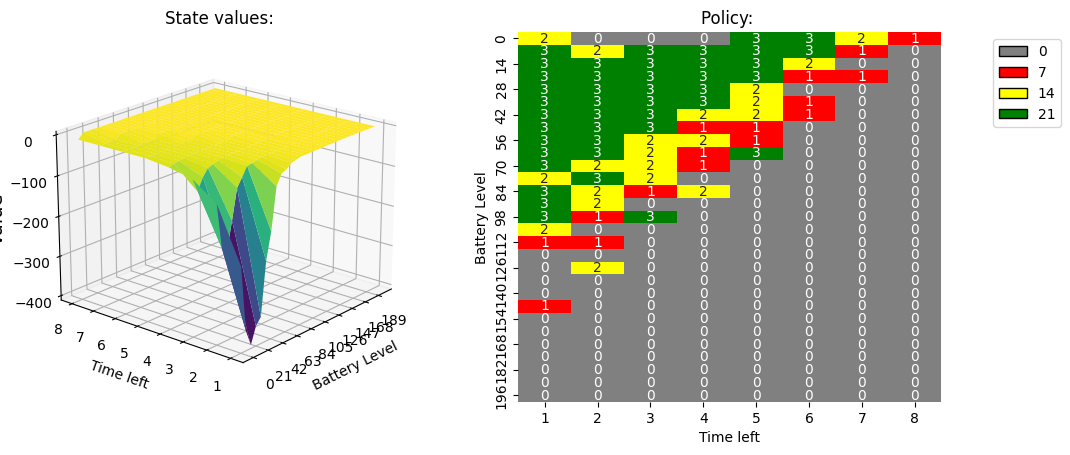

In [5]:
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    timstep, battery_level = np.meshgrid(
        np.arange(1, 9),
        np.arange(0, 200, 7),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([timstep, battery_level]),
    )
    value_grid = battery_level, timstep, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([timstep, battery_level]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    timstep, battery_level, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    #fig.suptitle(fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        timstep,
        battery_level,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0, 200, 21), range(0, 200, 21))
    plt.yticks(range(1, 9), range(1, 9))
    ax1.set_title(f"State values: ")
    ax1.set_xlabel("Battery Level")
    ax1.set_ylabel("Time left")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    cmap = ["grey", "red", "yellow", "green"]
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=cmap, cbar=False)
    ax2.set_title(f"Policy: ")
    ax2.set_xlabel("Time left")
    ax2.set_ylabel("Battery Level")
    ax2.set_xticklabels(range(1, 9))
    ax2.set_yticklabels(range(0, 200, 14))

    # add a legend
    legend_elements = [
        Patch(facecolor="grey", edgecolor="black", label="0"),
        Patch(facecolor="red", edgecolor="black", label="7"),
        Patch(facecolor="yellow", edgecolor="black", label="14"),
        Patch(facecolor="green", edgecolor="black", label="21"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent)
fig1 = create_plots(value_grid, policy_grid)
plt.show()

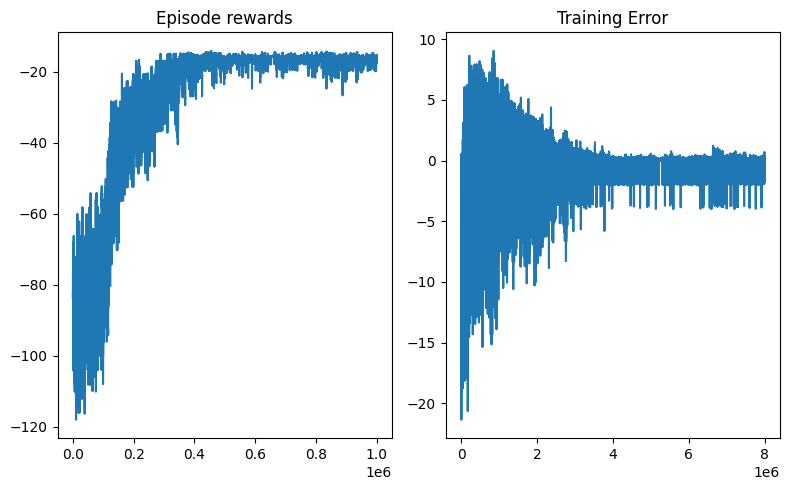

In [6]:

rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[1].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## (Second RL-model advanced: Double Q-learning)

## Third RL-model: Deep Q-learning
Build this in Google Colab with GPU environment selected